---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 2. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

If you are using Google Colab, you can use the cell below to download and unzip the data.
If you are running on your computer, you will need to do this yourself.

In [75]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip UCMerced_LandUse.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


Use this first cell to import the necessary libraries.

In [76]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
import torchvision.models as models

# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc)
2.	create the dataloader to load the data; remember to include here any normalization, data augmentation, or other technique used to pre-process the data


In [77]:
# Define transformations for train vs test and validate (normalization and augmentation)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Set our random seeds
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Load datasets
data_dir = r'UCMerced_LandUse/Images' 
train_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=train_transform)
test_val_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=test_val_transform)

# Define our classes
classes = train_dataset.classes

# Split dataset into train (70%), validate (10%) and test (20%)
n = len(train_dataset)
train_size = int(0.7 * n)
val_size = int(0.1 * n)
test_size = n - (train_size + val_size)

# Create and shuffle our indicies
indices = list(range(n))
np.random.shuffle(indices)

# Create appropiate subsets
train_dataset = Subset(train_dataset, indices[:train_size])
val_dataset = Subset(test_val_dataset, indices[train_size:-test_size])
test_dataset = Subset(test_val_dataset, indices[-test_size:])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=2)


---

# 2. **Neural Networks**

Here, you need to:

1.	propose your own Convolutional Neural Network (CNN) to tackle the problem;
2.	define at least one existing CNN (such as AlexNet, VGG, ResNet, DenseNet, etc) to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train your proposed architecture from scratch using your training set;
5.	train the existing architecture using at least 2 different strategies (i.e., trained from scratch, fine-tuning, feature extractor, etc);
6.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.



In [78]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [79]:
# Define a function to train our models and retain the necessary information

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Compute average training loss and accuracy
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Evaluation phase
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)

        # Compute average test loss and accuracy
        epoch_test_loss = running_test_loss / len(test_loader)
        epoch_test_acc = 100 * correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
              f"Validation Loss: {epoch_test_loss:.4f}, Validation Acc: {epoch_test_acc:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [80]:
# Define a function to plot the loss curve
def plot_loss(model_name, train_losses, test_losses):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss', linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss for ' + model_name)

    plt.show()


# Define a function to plot the accuracy curve
def plot_acc(model_name, train_accuracies, test_accuracies):
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Validation Accuracy', linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training vs Validation Accuracy for ' + model_name)

    plt.show()

In [ ]:
# ResNet50 with fine tuning implementation

# Load ResNet50 without pre-trained weights
ResNet_FT = models.resnet50(weights=None)

# Load the pre-trained weights from the downloaded file
ResNet_FT.load_state_dict(torch.load('resnet50-19c8e357.pth', map_location=device, weights_only= False))

# Move the model to the desired device (GPU/CPU)
ResNet_FT = ResNet_FT.to(device)

# Define components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet_FT.parameters(), lr=1e-3)

# Train the ResNet50 fine tuning
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    ResNet_FT, train_loader, val_loader, criterion, optimizer, num_epochs=10)

plot_loss('ResNet50 fine tuning', train_losses, val_losses)
plot_acc('ResNet50 fine tuning', train_accuracies, val_accuracies)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\maddy/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>

In [82]:
#ResNet50 from scratch implementation

# Define the residual block class
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    # Define the forward pass of the block
    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x) 
       
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
            
        x += identity
        x = self.relu(x)
        return x

# ResNet50 [3, 4, 6, 3]
class ResNet(nn.Module): 
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*4, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x
        
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1,
                                                        stride=stride), nn.BatchNorm2d(out_channels * 4))
            
            #the layer which change the number of channels, out_channels gonna be 64 * 4 = 256
            layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
            self.in_channels = out_channels * 4 
            
            for i in range(num_residual_blocks - 1):
                layers.append(block(self.in_channels, out_channels)) #256 -> 64, 64*4(256) again
                
            return nn.Sequential(*layers)
        
def ResNet50(img_channels=3, num_classes=21):
    return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)

# Initialize model
ResNet_Scratch = ResNet50(3, len(classes)).to(device)
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet_Scratch.parameters(), lr=1e-3, weight_decay=1e-4)
    
# Train the model
train_losses, val_losses, train_accs, val_accs = train_model(
        ResNet_Scratch, train_loader, val_loader, criterion, optimizer, num_epochs=15)
    
# Plot results
plot_loss('ResNet50 from scratch', train_losses, val_losses)
plot_acc('ResNet50 from scratch', train_accs, val_accs)

Epoch 1/20 - Train Loss: 3.1006, Train Acc: 16.12% | Validation Loss: 5.4060, Validation Acc: 12.38%
Epoch 2/20 - Train Loss: 2.3621, Train Acc: 25.17% | Validation Loss: 3.5415, Validation Acc: 18.57%
Epoch 3/20 - Train Loss: 2.2582, Train Acc: 33.40% | Validation Loss: 2.4242, Validation Acc: 29.52%
Epoch 4/20 - Train Loss: 2.1040, Train Acc: 33.81% | Validation Loss: 2.5887, Validation Acc: 34.29%
Epoch 5/20 - Train Loss: 1.8812, Train Acc: 38.84% | Validation Loss: 2.2727, Validation Acc: 35.24%
Epoch 6/20 - Train Loss: 1.7513, Train Acc: 43.33% | Validation Loss: 1.7352, Validation Acc: 47.14%
Epoch 7/20 - Train Loss: 1.6378, Train Acc: 46.53% | Validation Loss: 3.0633, Validation Acc: 27.62%


KeyboardInterrupt: 

Epoch 1/20 - Train Loss: 2.5488, Train Acc: 22.99% | Validation Loss: 2.6799, Validation Acc: 17.14%
Epoch 2/20 - Train Loss: 2.1076, Train Acc: 37.21% | Validation Loss: 2.1878, Validation Acc: 35.95%
Epoch 3/20 - Train Loss: 1.8741, Train Acc: 45.51% | Validation Loss: 1.8481, Validation Acc: 45.95%
Epoch 4/20 - Train Loss: 1.6933, Train Acc: 48.91% | Validation Loss: 1.8534, Validation Acc: 42.62%
Epoch 5/20 - Train Loss: 1.6041, Train Acc: 52.93% | Validation Loss: 1.7053, Validation Acc: 48.81%
Epoch 6/20 - Train Loss: 1.4600, Train Acc: 54.83% | Validation Loss: 1.5457, Validation Acc: 55.24%
Epoch 7/20 - Train Loss: 1.3794, Train Acc: 57.69% | Validation Loss: 1.5000, Validation Acc: 52.62%
Epoch 8/20 - Train Loss: 1.3020, Train Acc: 60.41% | Validation Loss: 1.4270, Validation Acc: 52.38%
Epoch 9/20 - Train Loss: 1.2484, Train Acc: 62.52% | Validation Loss: 1.3354, Validation Acc: 61.67%
Epoch 10/20 - Train Loss: 1.1762, Train Acc: 65.37% | Validation Loss: 1.3227, Validation A

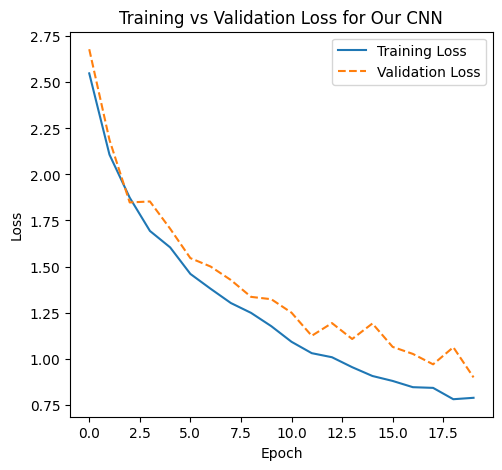

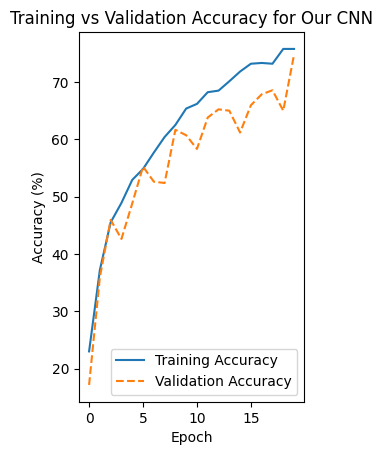

In [ ]:
# Define our own CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # input 128 x 128 x 3

        # Layer 1
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same')
        self.act = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.mp1 = nn.MaxPool2d(2, 2)  # output: 64 x 64 x 16

        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        # output: 32 x 32 x 32

        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        # output: 16 x 16 x 64

        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, 3, padding='same')
        self.dropout = nn.Dropout(0.2)
        self.bn4 = nn.BatchNorm2d(128)
        # output: 8 x 8 x 128

        # Classification
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 21)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.mp1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.mp1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.mp1(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.mp1(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


proposed_model = CNN()

# Move the model to the desired device (GPU/CPU)
proposed_model = proposed_model.to(device)

# Define components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(proposed_model.parameters(), lr=1e-3, weight_decay=1e-4)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    proposed_model, train_loader, test_loader, criterion, optimizer, num_epochs=20
)

plot_loss('Our CNN', train_losses, val_losses)
plot_acc('Our CNN', train_accuracies, val_accuracies)

---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best one you obtained in the above stage) on the testing dataset.


Overall Accuracy: 90.95%


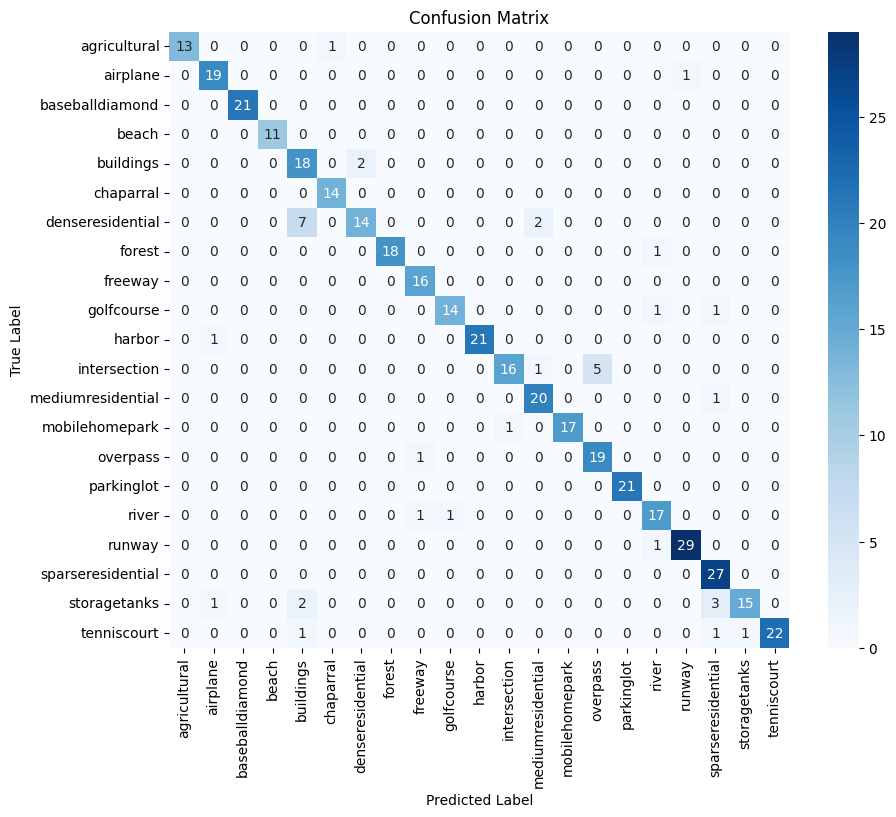

                   precision    recall  f1-score     support
agricultural        1.000000  0.928571  0.962963   14.000000
airplane            0.904762  0.950000  0.926829   20.000000
baseballdiamond     1.000000  1.000000  1.000000   21.000000
beach               1.000000  1.000000  1.000000   11.000000
buildings           0.642857  0.900000  0.750000   20.000000
chaparral           0.933333  1.000000  0.965517   14.000000
denseresidential    0.875000  0.608696  0.717949   23.000000
forest              1.000000  0.947368  0.972973   19.000000
freeway             0.888889  1.000000  0.941176   16.000000
golfcourse          0.933333  0.875000  0.903226   16.000000
harbor              1.000000  0.954545  0.976744   22.000000
intersection        0.941176  0.727273  0.820513   22.000000
mediumresidential   0.869565  0.952381  0.909091   21.000000
mobilehomepark      1.000000  0.944444  0.971429   18.000000
overpass            0.791667  0.950000  0.863636   20.000000
parkinglot          1.00

In [84]:
# Function to evaluate the model and generate reports
def evaluate_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    overall_accuracy = report['accuracy']
    print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
    
    # Convert classification report to DataFrame
    df_report = pd.DataFrame(report).transpose()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    return df_report

# Call the function
df_results = evaluate_model_with_metrics(ResNet_FT, test_loader, classes)

# Display results table
print(df_results)

